In [31]:
import os
import cv2
import numpy as np
import pandas as pd
import anndata as ad
from PIL import Image
from sklearn.cluster import KMeans
import scanpy as sc
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

# Uploading the AnnData

In [32]:
parent_folder = os.getcwd()
subfolder_name = "adata_baroque_paintings"
file_name = "adata_baroque_paintings_trial6_complementarity.h5ad"

save_path = os.path.join(parent_folder, subfolder_name, file_name)
adata_baroque_paintings_full = sc.read_h5ad(save_path)

In [33]:
adata_baroque_paintings_full

AnnData object with n_obs × n_vars = 286 × 120
    obs: 'Painting_name', 'Width', 'Height', 'Commission_Year', 'Completion_Year', 'Painter', 'sacred', 'Jesuit_Art', 'Baroque_Art', 'Laplacian_Contrast', 'Gradient_Contrast', 'Hybrid_Contrast', 'File Name', 'color_prop_1', 'color_prop_2', 'color_prop_3', 'color_prop_4', 'color_prop_5', 'color_prop_6', 'color_prop_7', 'color_prop_8', 'color_prop_9', 'color_prop_10', 'color_prop_11', 'color_prop_12', 'color_prop_13', 'color_prop_14', 'color_prop_15', 'color_prop_16', 'color_prop_17', 'color_prop_18', 'color_prop_19', 'color_prop_20', 'not_sacred', 'not_Baroque_Art', 'not_Jesuit_Art', 'color_complementarity_score'

In [34]:
adata_baroque_paintings_full.obs

,Painting_name,Width,Height,Commission_Year,Completion_Year,Painter,sacred,Jesuit_Art,Baroque_Art,Laplacian_Contrast,...,color_prop_15,color_prop_16,color_prop_17,color_prop_18,color_prop_19,color_prop_20,not_sacred,not_Baroque_Art,not_Jesuit_Art,color_complementarity_score
Painting_index,,,,,,,,,,,,,,,,,,,,,
1,David with the Head of Goliath,91.3,110.4,1595,1605,Michelangelo Merisi Caravaggio,1,0,1,0.010107,...,0.016200,0.015300,0.014675,0.014350,0.007175,0.006875,0,0,1,0.042089
2,Santa Catalina,128.0,166.0,1598,1599,Michelangelo Merisi Caravaggio,1,0,1,0.007477,...,0.007125,0.007075,0.005350,0.004650,0.003400,0.003400,0,0,1,0.083127
3,Imposición de la casulla a san Ildefonso,55.0,33.0,1600,1600,Peter Paul Rubens,1,0,1,0.015918,...,0.019925,0.019325,0.018600,0.018125,0.011225,0.004700,0,0,1,0.082595
4,La Sagrada Familia,23.0,35.0,1600,1600,Peter Paul Rubens,1,0,1,0.009649,...,0.029500,0.024050,0.013775,0.005925,0.004725,0.004000,0,0,1,0.005416
5,Vulcano y el fuego,126.0,140.0,1600,1600,Peter Paul Rubens,0,0,1,0.012177,...,0.018350,0.016900,0.015575,0.009400,0.007875,0.005100,1,0,1,0.003148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,La Berceuse,0.0,0.0,1888,1888,Vincent van Gogh,0,0,0,0.050316,...,0.028325,0.027550,0.027175,0.026075,0.024800,0.013250,1,1,1,0.119284
283,Self_protrait_VanGogh,0.0,0.0,1889,1889,Vincent van Gogh,0,0,0,0.053616,...,0.023825,0.023425,0.016750,0.015975,0.015425,0.013925,1,1,1,0.372845
284,Selfportrait_with_grey_felt_hat,0.0,0.0,1887,1888,Vincent van Gogh,0,0,0,0.053712,...,0.031175,0.029200,0.028050,0.025850,0.020450,0.009925,1,1,1,0.552021


# Filter only Baroque Paintings

In [35]:
adata_baroque_mask = adata_baroque_paintings_full.obs["Baroque_Art"] == 1
adata_baroque_paintings = adata_baroque_paintings_full[adata_baroque_mask].copy()
adata_baroque_paintings

AnnData object with n_obs × n_vars = 207 × 120
    obs: 'Painting_name', 'Width', 'Height', 'Commission_Year', 'Completion_Year', 'Painter', 'sacred', 'Jesuit_Art', 'Baroque_Art', 'Laplacian_Contrast', 'Gradient_Contrast', 'Hybrid_Contrast', 'File Name', 'color_prop_1', 'color_prop_2', 'color_prop_3', 'color_prop_4', 'color_prop_5', 'color_prop_6', 'color_prop_7', 'color_prop_8', 'color_prop_9', 'color_prop_10', 'color_prop_11', 'color_prop_12', 'color_prop_13', 'color_prop_14', 'color_prop_15', 'color_prop_16', 'color_prop_17', 'color_prop_18', 'color_prop_19', 'color_prop_20', 'not_sacred', 'not_Baroque_Art', 'not_Jesuit_Art', 'color_complementarity_score'

# Splitting the Data into Target and Parameters

In [36]:
adata_baroque_paintings.var_names

Index(['color_1_R', 'color_1_G', 'color_1_B', 'color_2_R', 'color_2_G',
       'color_2_B', 'color_3_R', 'color_3_G', 'color_3_B', 'color_4_R',
       ...
       'color_17_V', 'color_18_H', 'color_18_S', 'color_18_V', 'color_19_H',
       'color_19_S', 'color_19_V', 'color_20_H', 'color_20_S', 'color_20_V'],
      dtype='object', length=120)

In [37]:
rgb_cols = [
    "color_1_H", "color_1_S", "color_1_V",
    "color_2_H", "color_2_S", "color_2_V",
    "color_3_H", "color_3_S", "color_3_V",
    "color_4_H", "color_4_S", "color_4_V",
    "color_5_H", "color_5_S", "color_5_V"
]
rgb_values = adata_baroque_paintings[:, rgb_cols].X

df_rgb = pd.DataFrame(
    rgb_values,
    columns=rgb_cols,
    index=adata_baroque_paintings.obs.index
)

In [38]:
X = pd.concat([adata_baroque_paintings.obs[["color_prop_1", "color_prop_2", "color_prop_3",  "color_prop_4",  "color_prop_5","Laplacian_Contrast","Gradient_Contrast","color_complementarity_score"]], df_rgb],axis=1)
Y_sacred = adata_baroque_paintings.obs["sacred"]
Y_jesuit = adata_baroque_paintings.obs["Jesuit_Art"]

In [39]:
# Split Data
X_train, X_test, Y_train_sacred, Y_test_sacred = train_test_split(X, Y_sacred, test_size = 0.2, random_state = 1234)

print(f'Number of Sacred Paintings in target: {sum(Y_sacred)}')
print(f'Number of Non-Sacred Paintings in target: {len(Y_sacred) - sum(Y_sacred)}')

# 1 is sacred and 0 is non-sacred

Number of Sacred Paintings in target: 128
Number of Non-Sacred Paintings in target: 79


## Rescaling Data

In [40]:
X

,color_prop_1,color_prop_2,color_prop_3,color_prop_4,color_prop_5,Laplacian_Contrast,Gradient_Contrast,color_complementarity_score,color_1_H,color_1_S,...,color_2_V,color_3_H,color_3_S,color_3_V,color_4_H,color_4_S,color_4_V,color_5_H,color_5_S,color_5_V
Painting_index,,,,,,,,,,,,,,,,,,,,,
1,0.216800,0.169650,0.135850,0.112775,0.073025,0.010107,0.039573,0.042089,0.027778,0.206897,...,0.137255,0.066667,0.357143,0.164706,0.071429,0.420000,0.196078,0.077381,0.474576,0.231373
2,0.479325,0.236375,0.064700,0.037850,0.032575,0.007477,0.024709,0.083127,0.194444,0.285714,...,0.094118,0.128205,0.433333,0.117647,0.086667,0.595238,0.164706,0.078947,0.703704,0.211765
3,0.114100,0.088600,0.087900,0.082025,0.072925,0.015918,0.039988,0.082595,0.133333,0.454545,...,0.450980,0.106667,0.531915,0.184314,0.112745,0.340000,0.392157,0.113095,0.400000,0.274510
4,0.094475,0.085800,0.083950,0.078425,0.075575,0.009649,0.033868,0.005416,0.076087,0.621622,...,0.329412,0.083333,0.451613,0.243137,0.087302,0.420000,0.196078,0.083333,0.634921,0.247059
5,0.187600,0.155375,0.132175,0.078050,0.069975,0.012177,0.028396,0.003148,0.083333,0.352941,...,0.172549,0.086957,0.396552,0.227451,0.100000,0.277778,0.141176,0.073529,0.492754,0.270588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.250725,0.178750,0.083475,0.065525,0.043500,0.022769,0.059367,0.104525,0.013889,0.480000,...,0.054902,0.015152,0.767442,0.168627,0.986111,0.324324,0.145098,0.018182,0.785714,0.274510
204,0.216825,0.127300,0.103850,0.071675,0.061575,0.006413,0.053594,0.392399,0.100000,0.188679,...,0.160784,0.083333,0.149254,0.262745,0.097222,0.141176,0.333333,0.098039,0.160377,0.415686
205,0.189100,0.151225,0.123350,0.089125,0.059725,0.023818,0.063769,0.107194,0.120370,0.428571,...,0.121569,0.126667,0.471698,0.207843,0.118280,0.462687,0.262745,0.126437,0.358025,0.317647


In [41]:
scaler = StandardScaler().set_output(transform="pandas")

X_train_rescaled = scaler.fit_transform(X_train)
X_test_rescaled = scaler.fit_transform(X_test)

In [42]:
len(X_train_rescaled)

165

In [43]:
len(X_test_rescaled)

42

# Multiple Classifiers

In [44]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, roc_auc_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

def get_model_by_name(model_name, model_params=None):
    
    if model_params is None:
        model_params = {}

    base_models = {
        'knn': KNeighborsClassifier(),
        'naive_bayes': GaussianNB(),
        'logistic_regression': LogisticRegression(max_iter=1000),
        'svm': SVC(probability=True),
        'decision_tree': DecisionTreeClassifier(random_state=1234),
        'random_forest': RandomForestClassifier(random_state=1234)
    }

    if model_name not in base_models:
        raise ValueError(f"Invalid model_name '{model_name}'. Choose from: {list(base_models.keys())}")

    model = base_models[model_name]
    model.set_params(**model_params)
    return model


def evaluate_models_with_cv(model_name, X_train, Y_train, X_test, Y_test, data_name, n_splits=5, model_params=None):
    
    
    print(f"\nEVALUATION FOR {data_name} DATA using {model_name.upper()}\n")
    
    model = get_model_by_name(model_name, model_params)
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1234)
    cv_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring='accuracy')
    print(f"Cross-validated Accuracy (train, {n_splits}-fold): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}\n")
    
    
    model.fit(X_train, Y_train)
    
    
    Y_pred_train = model.predict(X_train)
    Y_prob_train = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None

    Y_pred_test = model.predict(X_test)
    Y_prob_test = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    def evaluate_set(Y_true, Y_pred, Y_prob=None, dataset_name="Train"):
        print(f"--- {dataset_name} Data ---")
        
        # Accuracy
        acc = accuracy_score(Y_true, Y_pred)
        print(f"Accuracy: {acc:.4f}")
        
        # Sensitivity (Recall of positive class, sacred = 1)
        sens = recall_score(Y_true, Y_pred, pos_label=1)
        print(f"Sensitivity (Recall of sacred): {sens:.4f}")
        
        # Confusion Matrix
        cm = confusion_matrix(Y_true, Y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-sacred', 'sacred'])
        disp.plot()
        plt.show()
        
        # ROC-AUC and Curve
        if Y_prob is not None:
            auc = roc_auc_score(Y_true, Y_prob)
            print(f"ROC-AUC: {auc:.4f}")
            fpr, tpr, _ = roc_curve(Y_true, Y_prob)
            plt.figure(figsize=(7, 5))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve ({dataset_name})')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.show()
    
    # Evaluate training and test sets
    evaluate_set(Y_train, Y_pred_train, Y_prob_train, dataset_name="Training")
    evaluate_set(Y_test, Y_pred_test, Y_prob_test, dataset_name="Testing")
    
    return model, cv_scores

# 1 Logistic Regression


EVALUATION FOR Baroque Paintings DATA using LOGISTIC_REGRESSION

Cross-validated Accuracy (train, 5-fold): 0.5515 ± 0.0121

--- Training Data ---
Accuracy: 0.6667
Sensitivity (Recall of sacred): 0.6250


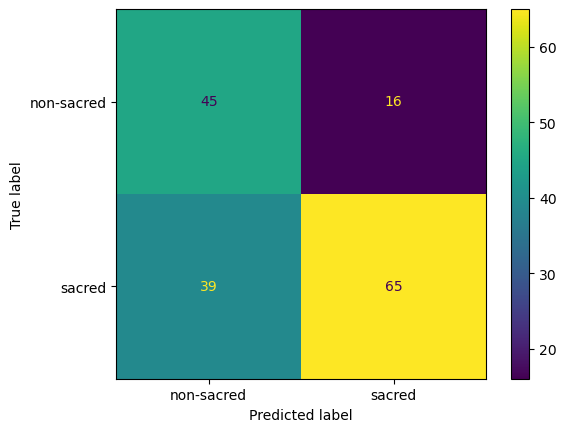

ROC-AUC: 0.7096


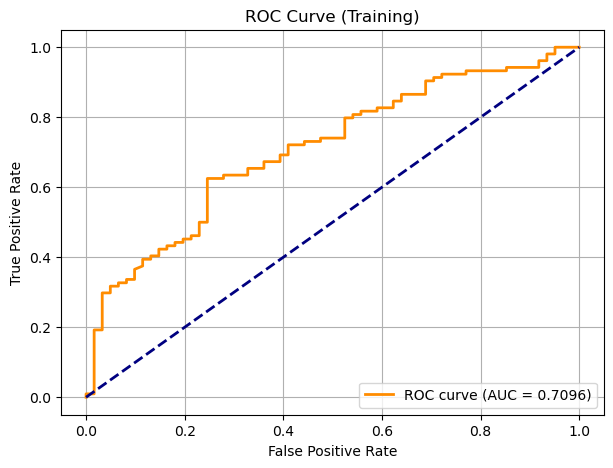

--- Testing Data ---
Accuracy: 0.6905
Sensitivity (Recall of sacred): 0.8333


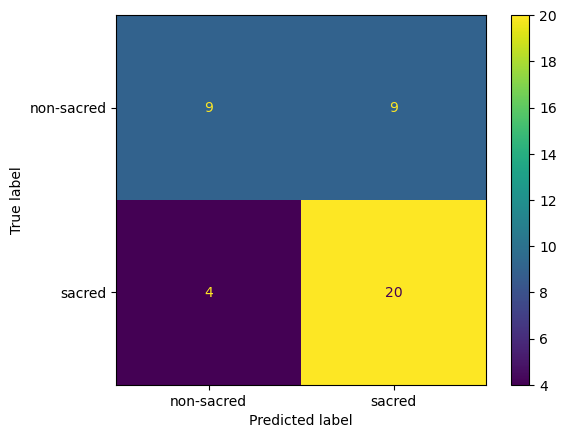

ROC-AUC: 0.7315


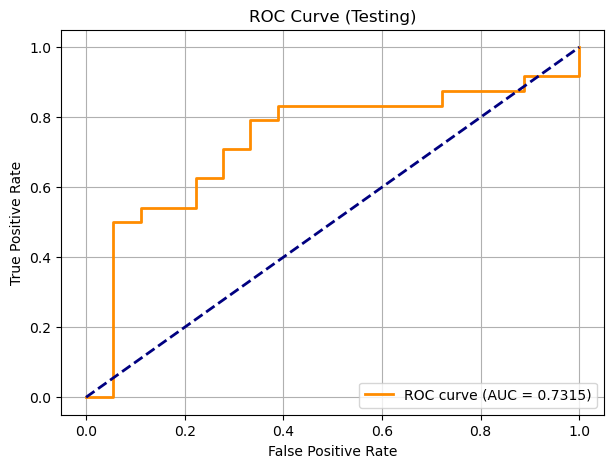

In [45]:
lr_params = {
    "penalty": "l2",
    "C": 1.0,
    "solver": "lbfgs",
    "class_weight": "balanced",
    "random_state": 1234
}

model_lg, cv_results_lg = evaluate_models_with_cv(
    model_name="logistic_regression",
    X_train=X_train, Y_train=Y_train_sacred,
    X_test=X_test, Y_test=Y_test_sacred,
    data_name="Baroque Paintings",
    n_splits=5,
    model_params=lr_params
)

# 2 KMeans


EVALUATION FOR Baroque Paintings DATA using KNN

Cross-validated Accuracy (train, 5-fold): 0.6606 ± 0.1057

--- Training Data ---
Accuracy: 0.9939
Sensitivity (Recall of sacred): 0.9904


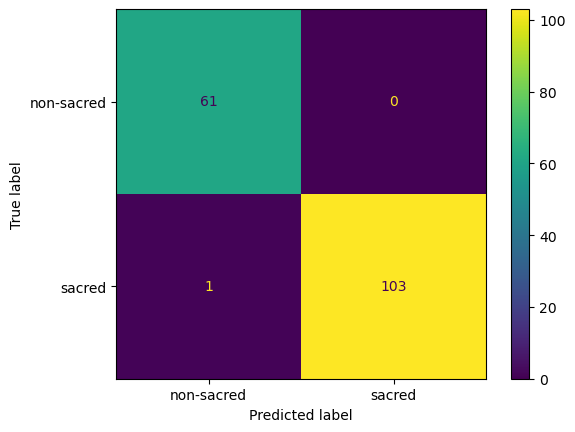

ROC-AUC: 0.9999


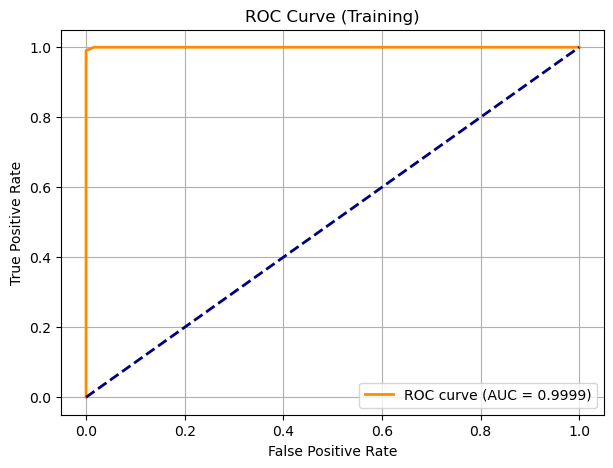

--- Testing Data ---
Accuracy: 0.6429
Sensitivity (Recall of sacred): 0.7917


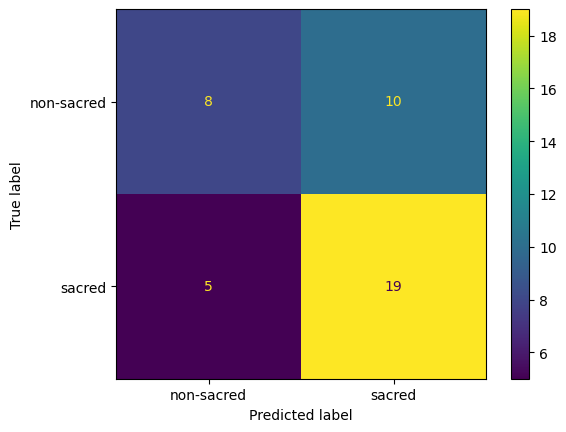

ROC-AUC: 0.6713


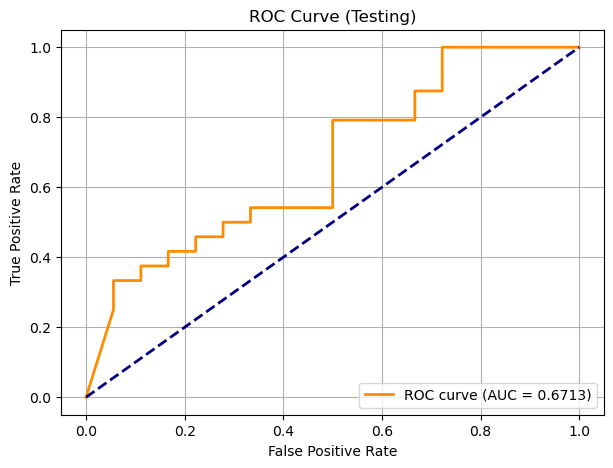

In [46]:
knn_params = {
    "n_neighbors": 5,             # Number of neighbors
    "weights": "distance",        # 'uniform' or 'distance'
    "algorithm": "auto",          # 'auto', 'ball_tree', 'kd_tree', 'brute'
    "leaf_size": 30,              # Leaf size for tree algorithms
    "p": 2,                       # Power parameter for Minkowski distance (1 = Manhattan, 2 = Euclidean)
    "n_jobs": -1                  # Parallel computation
}

model_kmeans, cv_results_kmeans = evaluate_models_with_cv(
    model_name="knn",
    X_train=X_train, Y_train=Y_train_sacred,
    X_test=X_test, Y_test=Y_test_sacred,
    data_name="Baroque Paintings",
    n_splits=5,
    model_params=knn_params
)

# 3 Naïve Bayes


EVALUATION FOR Baroque Paintings DATA using NAIVE_BAYES

Cross-validated Accuracy (train, 5-fold): 0.5697 ± 0.0887

--- Training Data ---
Accuracy: 0.6424
Sensitivity (Recall of sacred): 0.5962


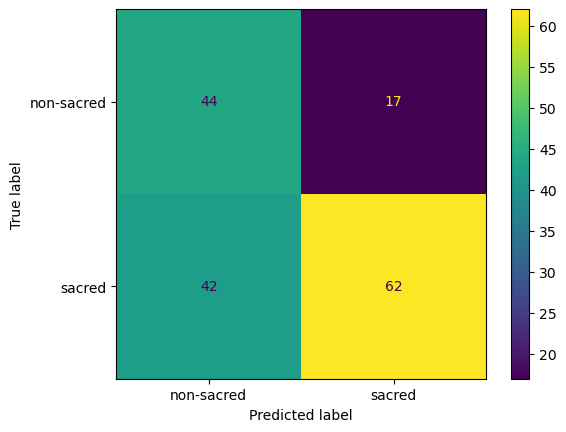

ROC-AUC: 0.7156


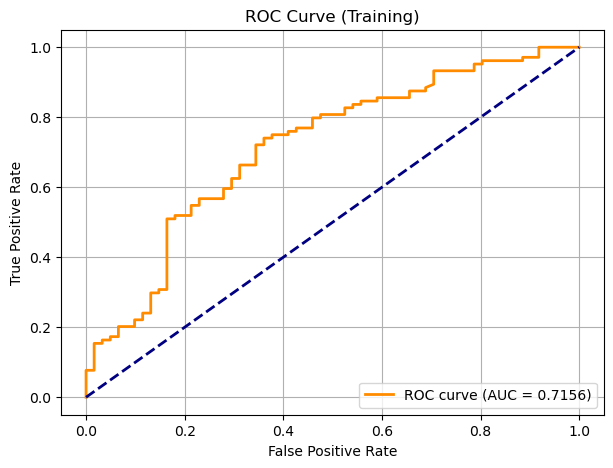

--- Testing Data ---
Accuracy: 0.6190
Sensitivity (Recall of sacred): 0.7500


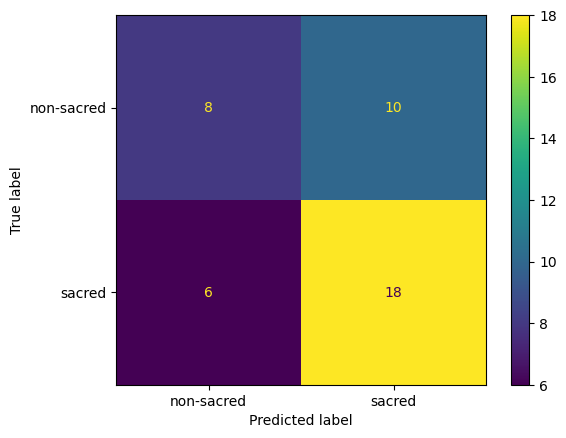

ROC-AUC: 0.6389


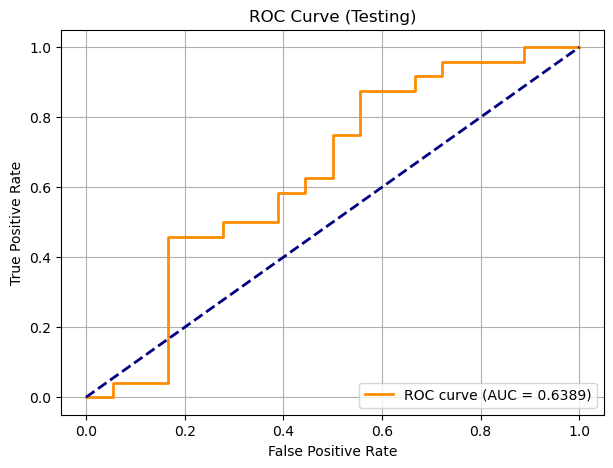

In [47]:
nb_params = {
    "priors": None,               # Class priors, e.g., [0.5, 0.5]
    "var_smoothing": 1e-9         # Additive smoothing to avoid zero variance
}

model_nb, cv_results_nb = evaluate_models_with_cv(
    model_name="naive_bayes",
    X_train=X_train, Y_train=Y_train_sacred,
    X_test=X_test, Y_test=Y_test_sacred,
    data_name="Baroque Paintings",
    n_splits=5,
    model_params=nb_params
)

# 4 SVM


EVALUATION FOR Baroque Paintings DATA using SVM

Cross-validated Accuracy (train, 5-fold): 0.6303 ± 0.0297

--- Training Data ---
Accuracy: 0.7030
Sensitivity (Recall of sacred): 1.0000


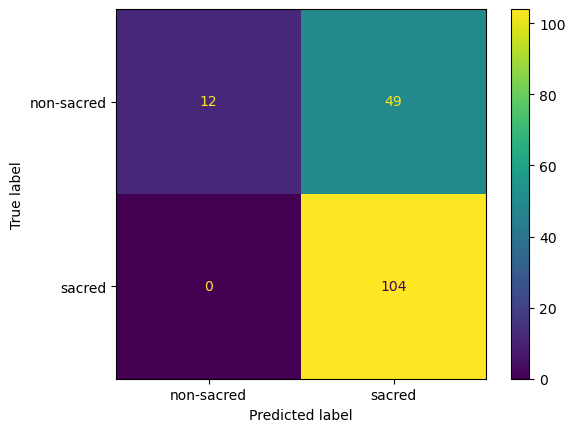

ROC-AUC: 0.1446


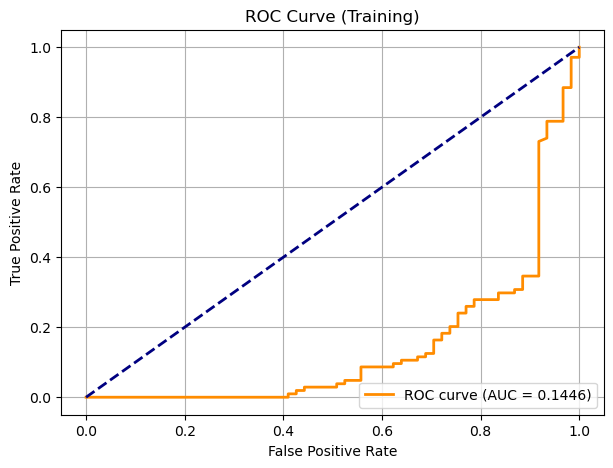

--- Testing Data ---
Accuracy: 0.5714
Sensitivity (Recall of sacred): 1.0000


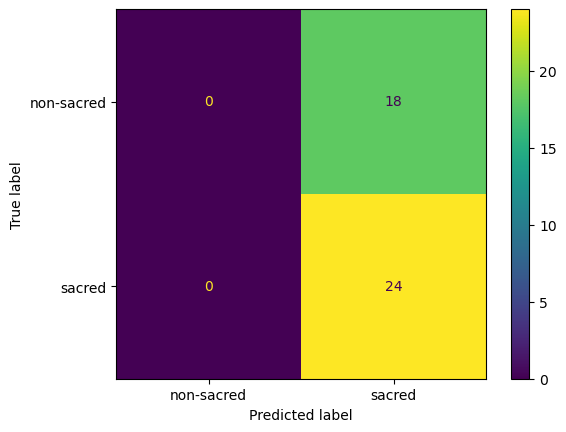

ROC-AUC: 0.2130


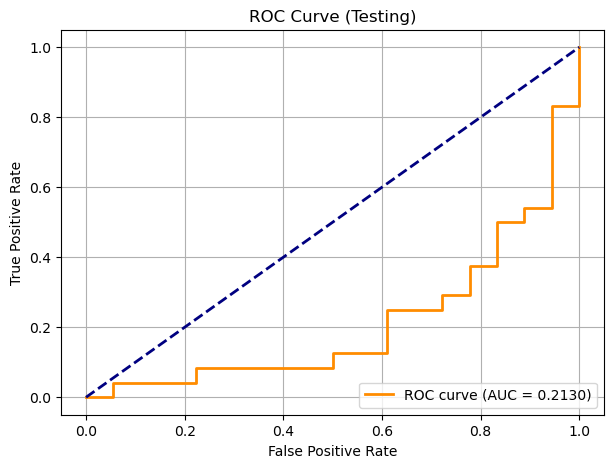

In [48]:
svm_params = {
    "C": 1.0,                     # Regularization parameter
    "kernel": "rbf",              # 'linear', 'poly', 'rbf', 'sigmoid'
    "degree": 3,                  # Only for 'poly'
    "gamma": "scale",             # 'scale', 'auto', or float
    "probability": True,          # Needed for ROC-AUC
    "class_weight": None,   # Handle imbalanced classes
    "random_state": 1234
}

model_svm, cv_results_svm = evaluate_models_with_cv(
    model_name="svm",
    X_train=X_train, Y_train=Y_train_sacred,
    X_test=X_test, Y_test=Y_test_sacred,
    data_name="Baroque Paintings",
    n_splits=5,
    model_params=svm_params
)

# 5 Decision Tree


EVALUATION FOR Baroque Paintings DATA using DECISION_TREE

Cross-validated Accuracy (train, 5-fold): 0.5697 ± 0.1263

--- Training Data ---
Accuracy: 0.9515
Sensitivity (Recall of sacred): 0.9327


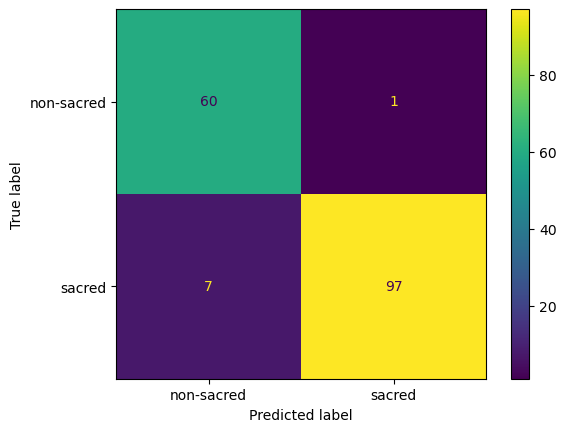

ROC-AUC: 0.9927


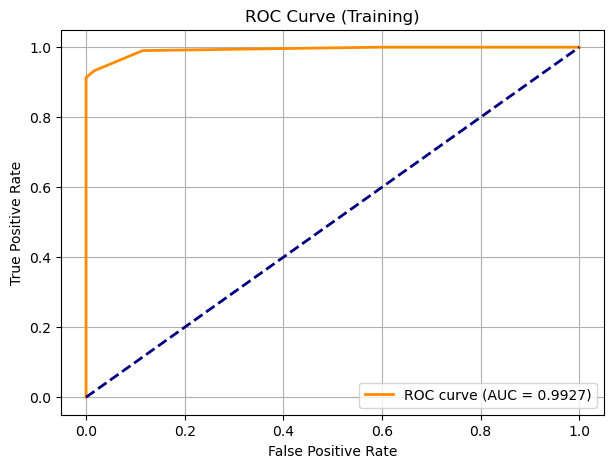

--- Testing Data ---
Accuracy: 0.5952
Sensitivity (Recall of sacred): 0.5417


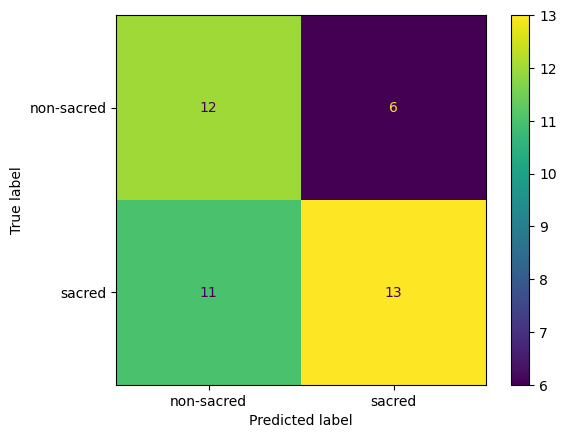

ROC-AUC: 0.6042


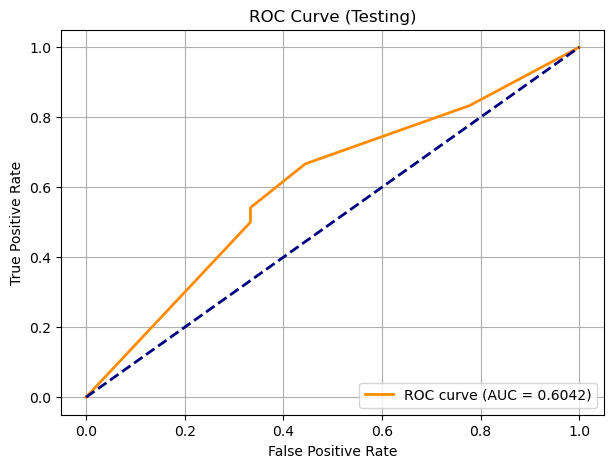

In [49]:
dt_params = {
    "criterion": "gini",          # 'gini' or 'entropy'
    "max_depth": 10,              # Maximum depth to avoid overfitting
    "min_samples_split": 4,       # Minimum samples to split an internal node
    "min_samples_leaf": 2,        # Minimum samples in leaf nodes
    "max_features": None,         # Max features to consider ('sqrt', 'log2', int, float)
    "class_weight": "balanced",   # For imbalanced classes
    "random_state": 1234
}

model_dt, cv_results_dt = evaluate_models_with_cv(
    model_name="decision_tree",
    X_train=X_train, Y_train=Y_train_sacred,
    X_test=X_test, Y_test=Y_test_sacred,
    data_name="Baroque Paintings",
    n_splits=5,
    model_params=dt_params
)

# Random Forest


EVALUATION FOR Baroque Paintings DATA using RANDOM_FOREST

Cross-validated Accuracy (train, 5-fold): 0.6606 ± 0.0588

--- Training Data ---
Accuracy: 0.9939
Sensitivity (Recall of sacred): 0.9904


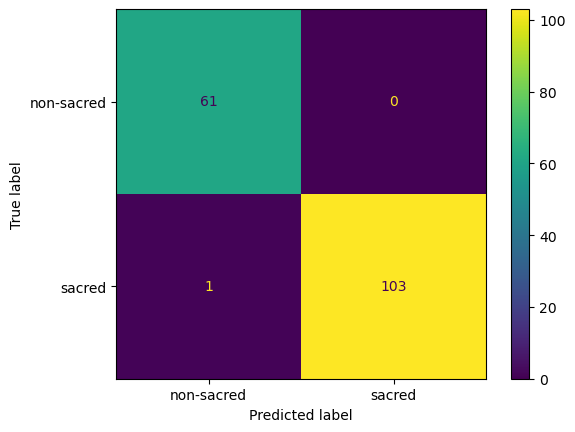

ROC-AUC: 0.9998


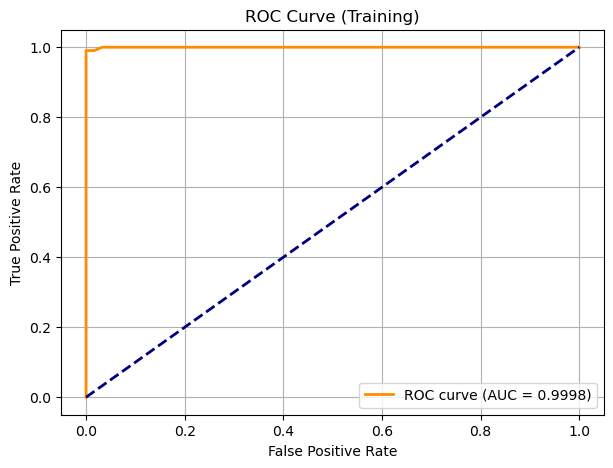

--- Testing Data ---
Accuracy: 0.6905
Sensitivity (Recall of sacred): 0.9167


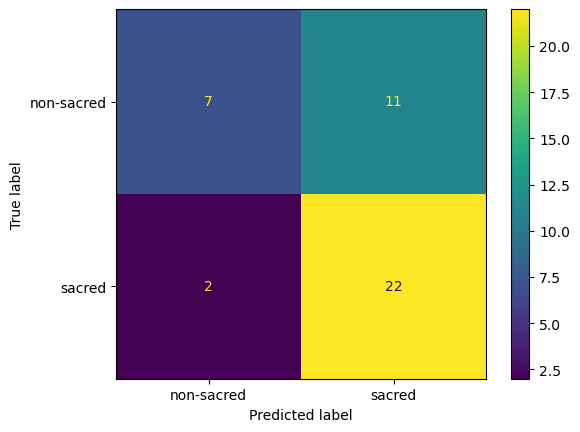

ROC-AUC: 0.7083


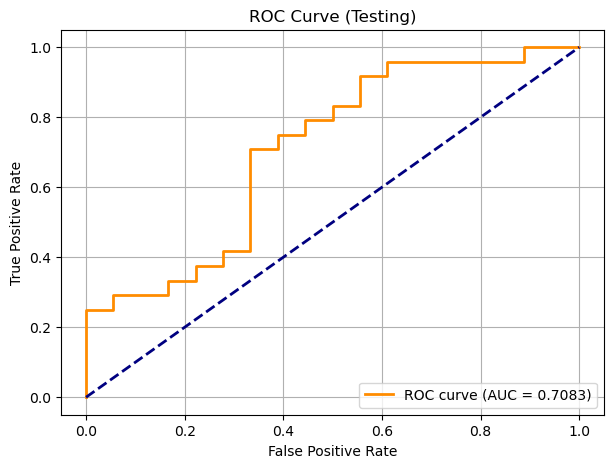

In [51]:
rf_params = {
    "n_estimators": 200,          # Number of trees
    "criterion": "gini",          # 'gini' or 'entropy'
    "max_depth": 20,              # Limit tree depth to reduce overfitting
    "min_samples_split": 5,       # Min samples to split a node
    "min_samples_leaf": 2,        # Min samples in a leaf
    "max_features": "sqrt",       # Number of features to consider per split ('sqrt', 'log2', int, float)
    "bootstrap": True,            # Sample with replacement
    "class_weight": "balanced",   # Adjust weights for imbalanced classes
    "random_state": 1234
}

model_rf, cv_results_rf = evaluate_models_with_cv(
    model_name="random_forest",
    X_train=X_train, Y_train=Y_train_sacred,
    X_test=X_test, Y_test=Y_test_sacred,
    data_name="Baroque Paintings",
    n_splits=5,
    model_params=rf_params
)


EVALUATION FOR Baroque Paintings DATA using RANDOM_FOREST

Cross-validated Accuracy (train, 5-fold): 0.6424 ± 0.0555

--- Training Data ---
Accuracy: 0.9879
Sensitivity (Recall of sacred): 1.0000


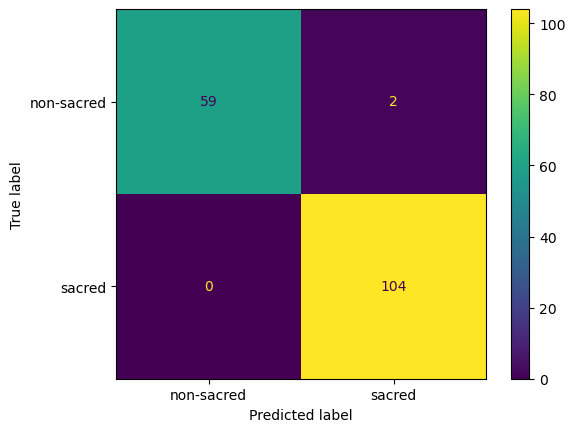

ROC-AUC: 0.9998


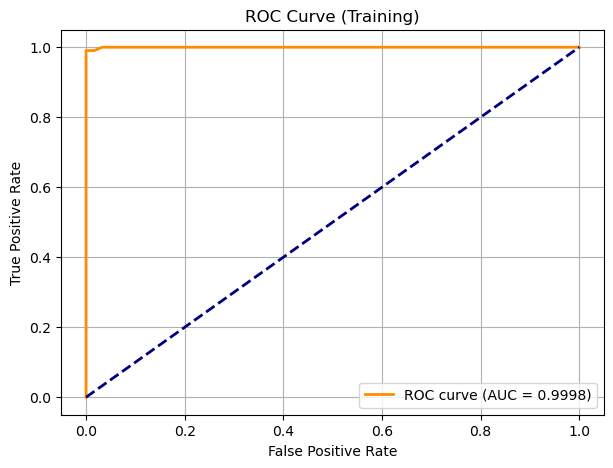

--- Testing Data ---
Accuracy: 0.7143
Sensitivity (Recall of sacred): 0.9583


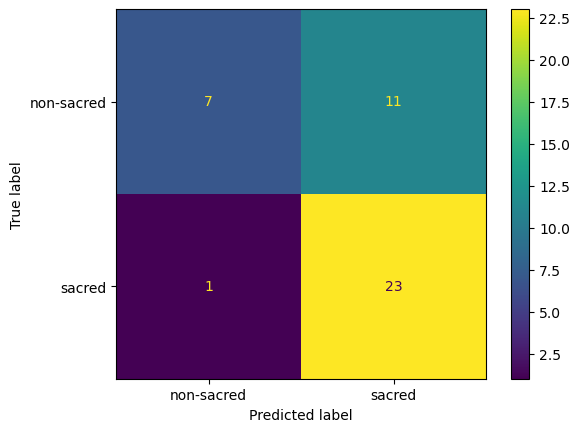

ROC-AUC: 0.6944


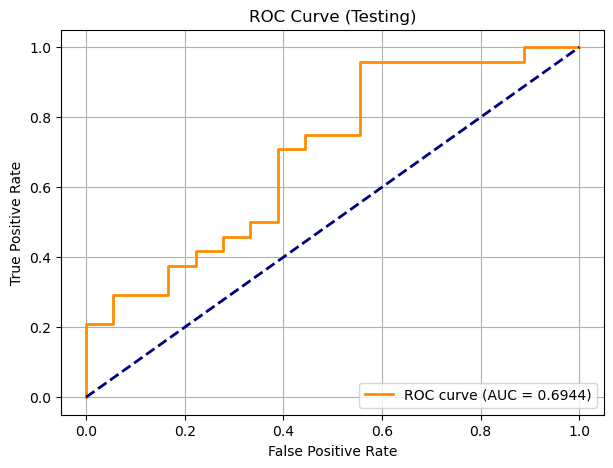

In [50]:
rf_params = {
    "n_estimators": 200,          # Number of trees
    "criterion": "gini",          # 'gini' or 'entropy'
    "max_depth": 20,              # Limit tree depth to reduce overfitting
    "min_samples_split": 5,       # Min samples to split a node
    "min_samples_leaf": 2,        # Min samples in a leaf
    "max_features": "sqrt",       # Number of features to consider per split ('sqrt', 'log2', int, float)
    "bootstrap": True,            # Sample with replacement
    "class_weight": None,   # Adjust weights for imbalanced classes
    "random_state": 1234
}

model_rf, cv_results_rf = evaluate_models_with_cv(
    model_name="random_forest",
    X_train=X_train, Y_train=Y_train_sacred,
    X_test=X_test, Y_test=Y_test_sacred,
    data_name="Baroque Paintings",
    n_splits=5,
    model_params=rf_params
)

EVALUATION FOR Baroque Paintings - Sacred vs Non-Sacred DATA:
For the training data


KNeighbors Classifier Accuracy: 0.7455
KNeighbors Classifier ROC-AUC: 0.7858


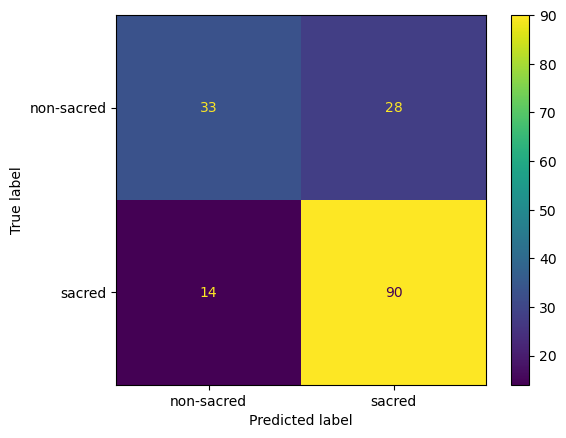

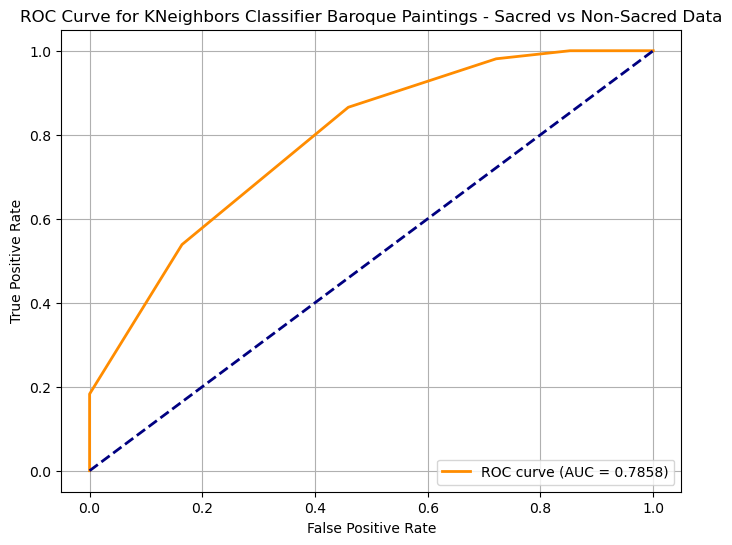

KNeighbors Classifier Sensitivity: 0.5410
-----------------------------------------


For the testing data


KNeighbors Classifier Accuracy: 0.6667
KNeighbors Classifier ROC-AUC: 0.6667


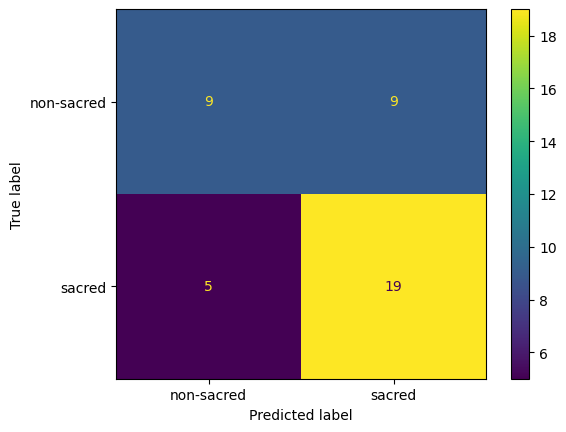

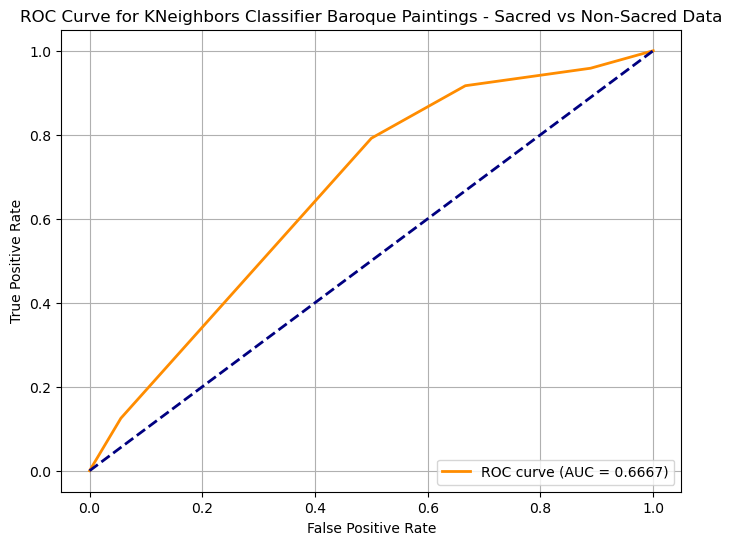

KNeighbors Classifier Sensitivity: 0.5000


In [23]:
evaluate(model = "knn",
         model_name = "KNeighbors Classifier",
         X_train = X_train_rescaled,
         Y_train = Y_train_sacred,
         X_test = X_test_rescaled,
         Y_test = Y_test_sacred,
         data_name = "Baroque Paintings - Sacred vs Non-Sacred")

EVALUATION FOR Baroque Paintings - Sacred vs Non-Sacred DATA:
For the training data


Naïve Bayes Classifier Accuracy: 0.6424
Naïve Bayes Classifier ROC-AUC: 0.7156


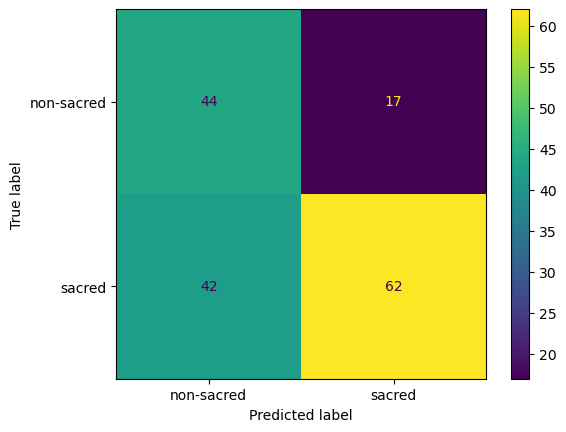

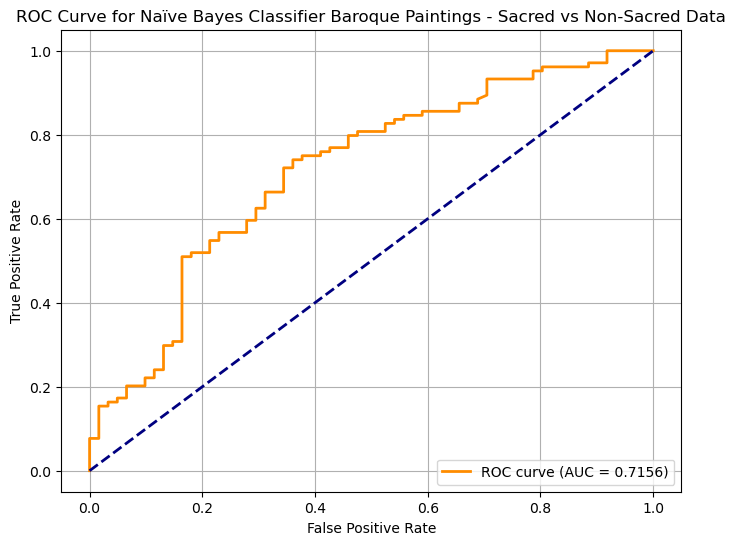

Naïve Bayes Classifier Sensitivity: 0.7213
-----------------------------------------


For the testing data


Naïve Bayes Classifier Accuracy: 0.6190
Naïve Bayes Classifier ROC-AUC: 0.6389


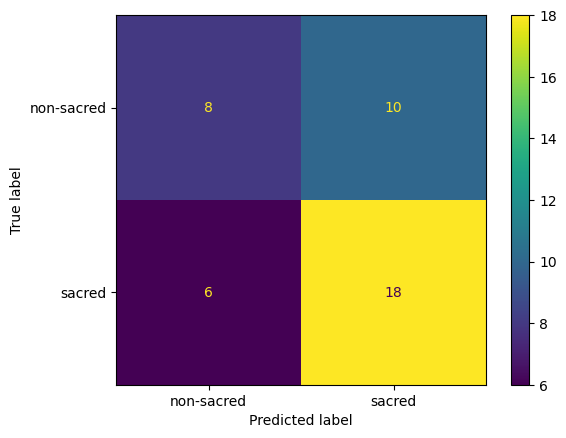

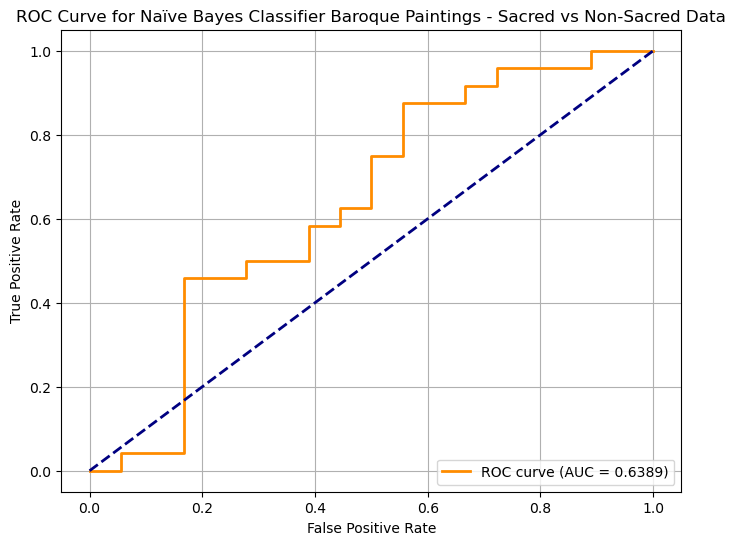

Naïve Bayes Classifier Sensitivity: 0.4444


In [24]:
evaluate(model = "naive_bayes",
         model_name = "Naïve Bayes Classifier",
         X_train = X_train,
         Y_train = Y_train_sacred,
         X_test = X_test,
         Y_test = Y_test_sacred,
         data_name = "Baroque Paintings - Sacred vs Non-Sacred")

EVALUATION FOR Baroque Paintings - Sacred vs Non-Sacred DATA:
For the training data


Logistic Regression Classifier Accuracy: 0.6848
Logistic Regression Classifier ROC-AUC: 0.7324


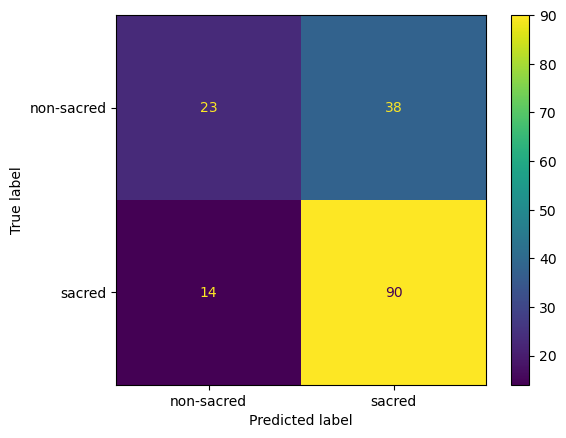

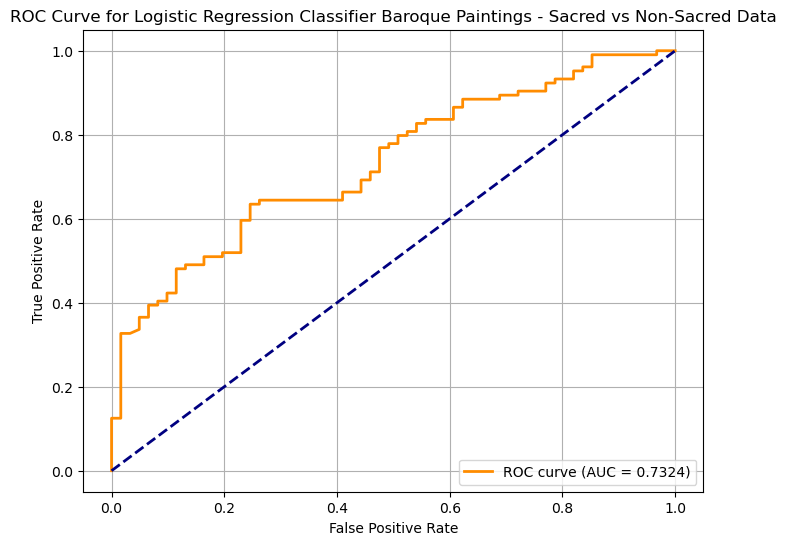

Logistic Regression Classifier Sensitivity: 0.3770
-----------------------------------------


For the testing data


Logistic Regression Classifier Accuracy: 0.6190
Logistic Regression Classifier ROC-AUC: 0.7338


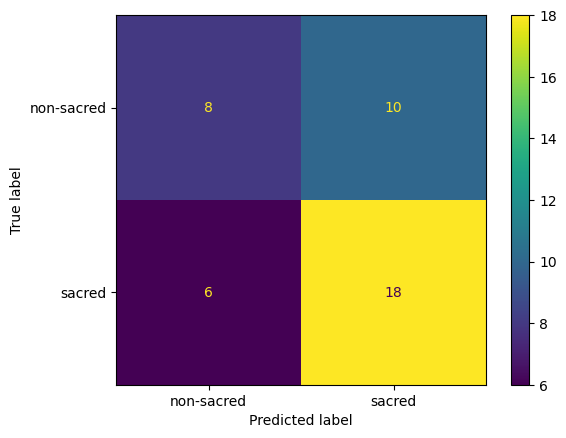

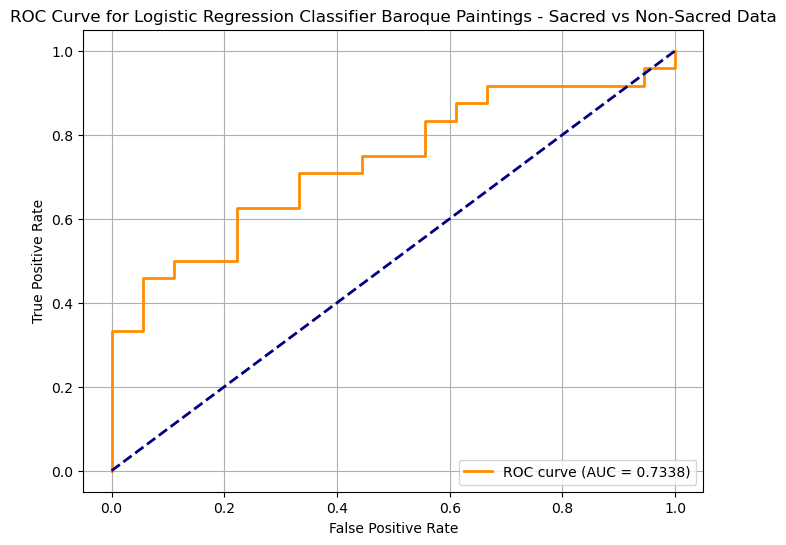

Logistic Regression Classifier Sensitivity: 0.4444


In [25]:
evaluate(model = "logistic_regression",
         model_name = "Logistic Regression Classifier",
         X_train = X_train_rescaled,
         Y_train = Y_train_sacred,
         X_test = X_test_rescaled,
         Y_test = Y_test_sacred,
         data_name = "Baroque Paintings - Sacred vs Non-Sacred")

EVALUATION FOR Baroque Paintings - Sacred vs Non-Sacred DATA:
For the training data


Support Vector Machine Accuracy: 0.8182
Support Vector Machine ROC-AUC: 0.0622


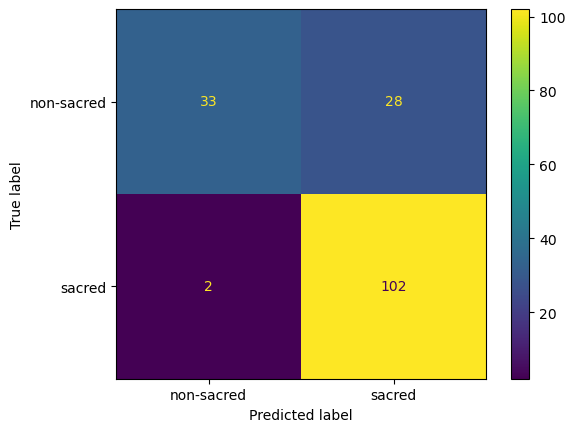

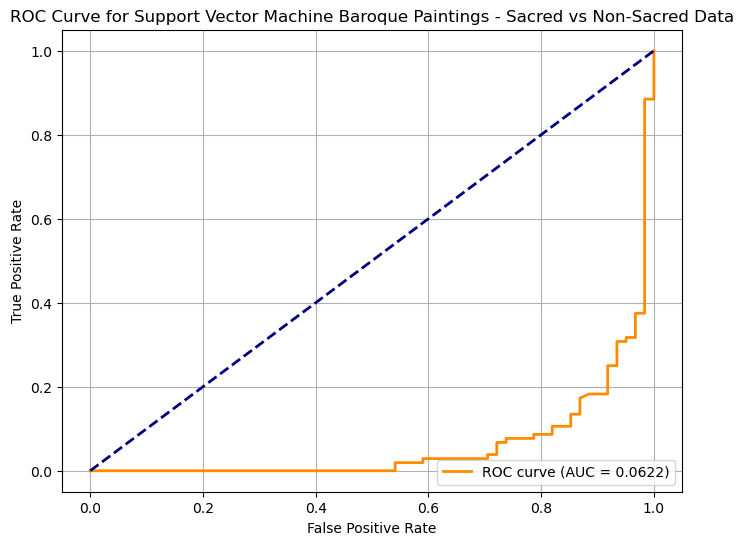

Support Vector Machine Sensitivity: 0.5410
-----------------------------------------


For the testing data


Support Vector Machine Accuracy: 0.6905
Support Vector Machine ROC-AUC: 0.2199


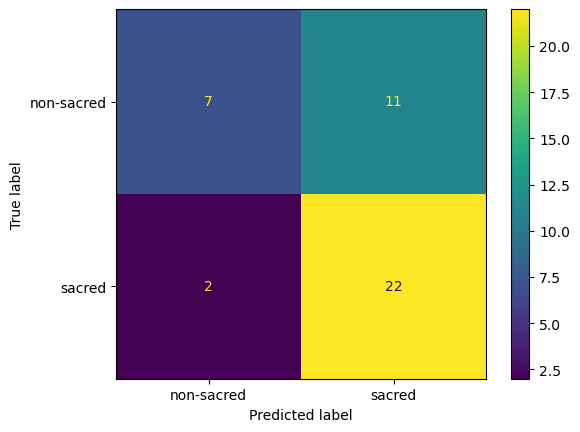

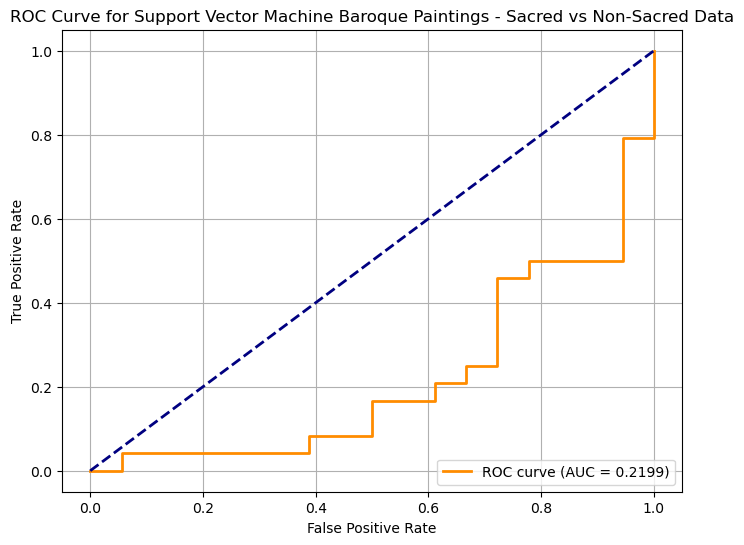

Support Vector Machine Sensitivity: 0.3889


In [26]:
evaluate(model = "svm",
         model_name = "Support Vector Machine",
         X_train = X_train_rescaled,
         Y_train = Y_train_sacred,
         X_test = X_test_rescaled,
         Y_test = Y_test_sacred,
         data_name = "Baroque Paintings - Sacred vs Non-Sacred")

EVALUATION FOR Baroque Paintings - Sacred vs Non-Sacred DATA:
For the training data


Decision Tree Classifier Accuracy: 0.9939
Decision Tree Classifier ROC-AUC: 0.9999


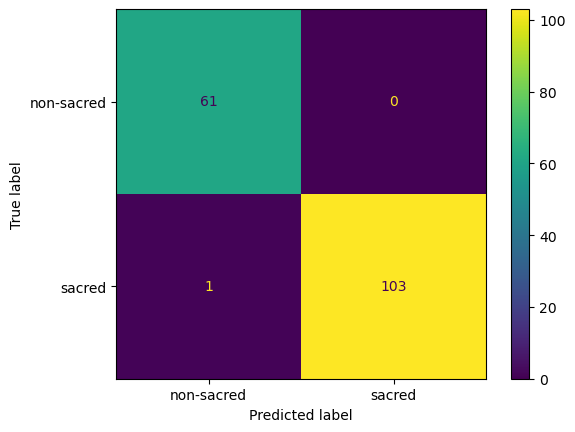

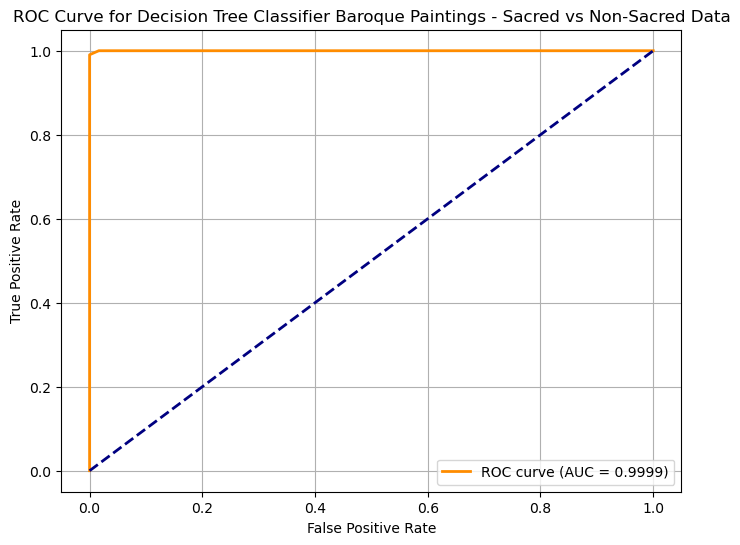

Decision Tree Classifier Sensitivity: 1.0000
-----------------------------------------


For the testing data


Decision Tree Classifier Accuracy: 0.6667
Decision Tree Classifier ROC-AUC: 0.6389


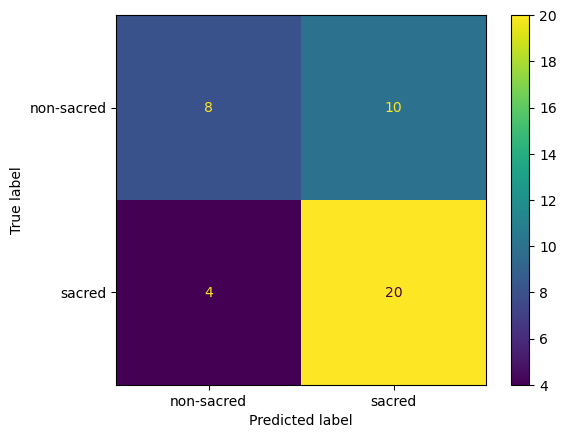

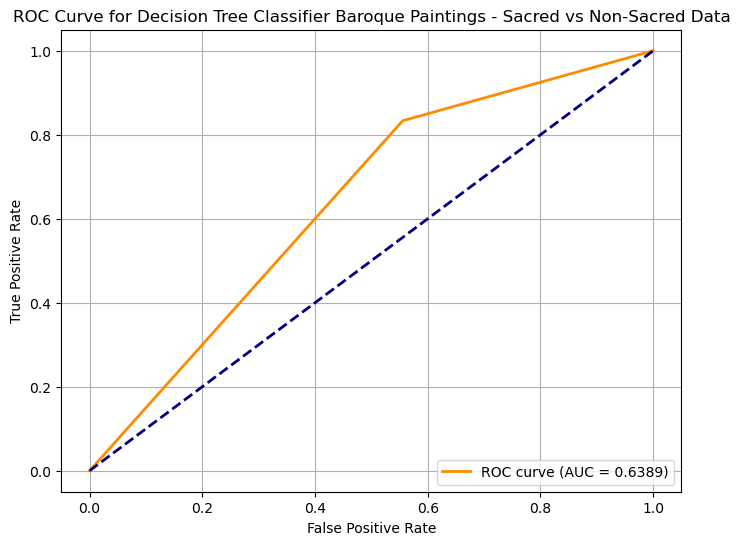

Decision Tree Classifier Sensitivity: 0.4444


In [27]:
evaluate(model = "decision_tree",
         model_name = "Decision Tree Classifier",
         X_train = X_train,
         Y_train = Y_train_sacred,
         X_test = X_test,
         Y_test = Y_test_sacred,
         data_name = "Baroque Paintings - Sacred vs Non-Sacred")

In [ ]:
#It seems that Random Forest Classifier is the best at classifying the paintings.

In [ ]:
#It also seems that the accuracy increases when using using HSV instead of RGB.